In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import os
from fredapi import Fred
from dotenv import load_dotenv, dotenv_values
from scipy.stats import norm

In [3]:
#assigning env variables
load_dotenv()
FED_API_KEY = os.getenv('FED_API_KEY')
FED_RATES = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30', 'DGS3MO', 'DGS6MO', 'DGS1MO', 'DGS2MO', 'DGS3MO', 'DGS6MO', 'T10YIE', 'FEDFUNDS']

In [4]:
#fetch risk free rate from fred data
def get_fred_data(rate_id):
    fred = Fred(api_key=FED_API_KEY)
    risk_free_rate = fred.get_series(rate_id).iloc[-1] / 100
    return risk_free_rate

In [5]:
#fetch yfinance stock data
def get_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    stock_price = stock.history(period='1d')['Close'][0]
    hist = stock.history(period=period)
    hist['returns'] = hist['Close'].pct_change()
    volatility = hist['returns'].std() * (252 ** 0.5)
    dividend = stock.info['dividendYield']
    return stock_price, volatility, hist, dividend

In [6]:
def get_time_period(expire_date):
    today = datetime.date.today()
    time_period = abs((expire_date - today).days)
    return time_period

In [7]:
def monte_carlo(S0, K, r, T, n, m, sd, option_type="Call", exercise_type="European"):
    '''
    S0 = initial stock price
    K = strike price
    r = risk-free rate
    T = time until expiry
    n = number of time steps
    m = number of price paths
    sd = volatility
    option_type = call or put option
    exercise_type = european or american
    '''

    #Time to expiry is given in days, so convert to years
    T = T / 252

    #Discretize the SDE
    deltaT = T / n

    stock_tree = np.zeros((n+1, m))
    stock_tree[0] = S0
    for t in range(1,n+1):
        stock_tree[t] = stock_tree[t-1]*np.exp((r -0.5*sd**2)*deltaT+sd*np.sqrt(deltaT)*np.random.standard_normal(m))
    
    #Calculate payoff for each path and find discounted value of option
    payoffs = np.zeros(m)
    if exercise_type == "European":
        if option_type == "Call":
            for i in range(m):
                payoffs[i] = max(stock_tree[n,i] - K, 0)
        if option_type == "Put":
            for i in range(m):
                payoffs[i] = max(K - stock_tree[n,i], 0)
        option_price = np.exp(-r*T) * np.mean(payoffs)
        se = np.exp(-r*T) * payoffs.std(ddof=1) / np.sqrt(m)
    else:
        raise ValueError("Wrong option exercise type specified.")
    return option_price,stock_tree,se




In [8]:
S0 = 100
K = 105
r = 0.06
T = 252
n = 100
m = 100000
sd = 0.3

opt_price, tree, error = monte_carlo(S0, K, r, T, n, m, sd, "Put", "European")


In [9]:

print(error)
print(tree)
print(opt_price)


0.04567009003404059
[[100.         100.         100.         ... 100.         100.
  100.        ]
 [ 99.47340801 102.70031995  95.46900265 ...  97.39696695 101.51015635
   97.68425379]
 [ 94.83336328 106.68839291  94.00170232 ...  99.41661847 101.32845864
  100.37265941]
 ...
 [166.12102649  86.99037439  93.77268806 ...  84.09852336  99.87619223
  128.69335433]
 [161.98176895  86.11574909  95.23102533 ...  84.61814835  98.41930988
  134.06680867]
 [163.79961381  90.96835122  92.17243386 ...  83.86708981  97.77824884
  131.51593501]]
11.436531931776399


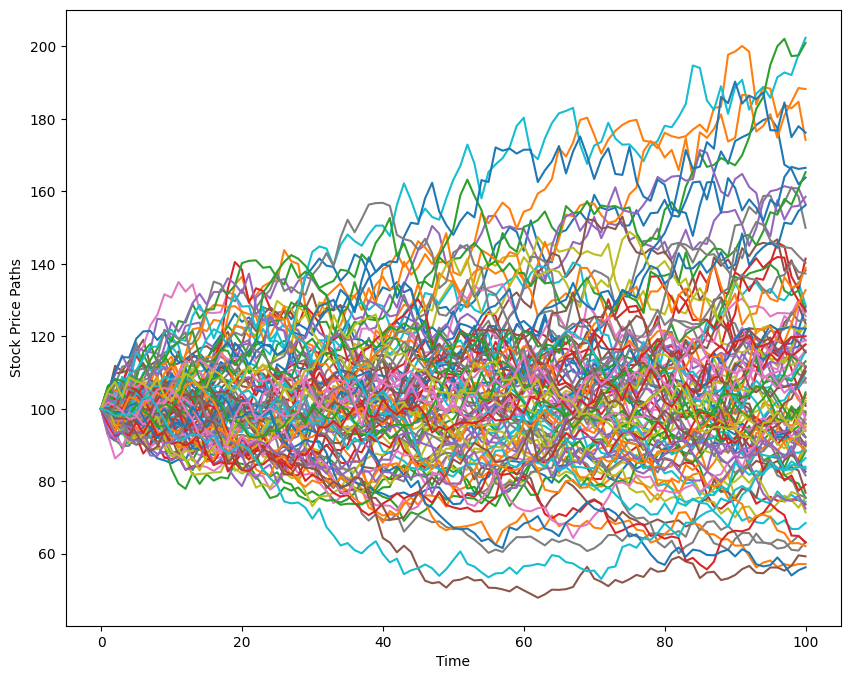

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(tree[:, :100])
plt.xlabel('Time')
plt.ylabel('Stock Price Paths')
plt.show()